In [2]:
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import time
import rosbag
from cv_bridge import CvBridge
import cv2
import transforms3d.quaternions as quaternions
import transforms3d.euler as euler
from robot_fk_new import *
from camera import *
from utils import *
from particle_filter import *
from fk_functions import *
import imutils
from scipy import optimize
from scipy.stats import norm

bridge = CvBridge()

# read data from rosbag

In [3]:
# Get a sample data!!
bag = rosbag.Bag('taurus_dataset/close_file2.bag')

robot_state_list = []
robot_state_ts   = []

img_list  = []
img_ts    = []

left_wrist_end_frame_list = []
left_wrist_end_frame_ts = []

opti_left_wrist_list = []
opti_left_wrist_ts = []

for topic, msg, t in bag.read_messages(topics=['/rgb/image_raw', 
                                               '/rgb/camera_info', 
                                               '/joint_states']):
    if topic == '/rgb/image_raw':
        img_list.append(msg)
        img_ts.append(msg.header.stamp.to_sec())
    elif topic == '/joint_states':
        robot_state_list.append(msg)
        robot_state_ts.append(msg.header.stamp.to_sec())
    elif topic == '/rgb/camera_info':
        camera_info = msg
    #elif topic == '/tf':
    #    if msg.transforms[0].child_frame_id == "left_wrist_end_frame":
    #        left_wrist_end_frame_list.append(msg.transforms[0])
    #        left_wrist_end_frame_ts.append(msg.transforms[0].header.stamp.to_sec())
    #    elif msg.transforms[0].child_frame_id == "opti_left_wrist":
    #        opti_left_wrist_list.append(msg.transforms[0])
    #        opti_left_wrist_ts.append(msg.transforms[0].header.stamp.to_sec())
        

bag.close()

# read camera parameters

In [4]:
P = np.array(camera_info.P).reshape(3,4)[:,:3]
D = np.array(camera_info.D)
offset = np.array([camera_info.roi.x_offset,camera_info.roi.y_offset])

img_ts  = np.array(img_ts)
robot_state_ts = np.array(robot_state_ts)
#left_wrist_end_frame_ts = np.array(left_wrist_end_frame_ts)

camera = Camera(P,D,offset)



# test marker detection on single image

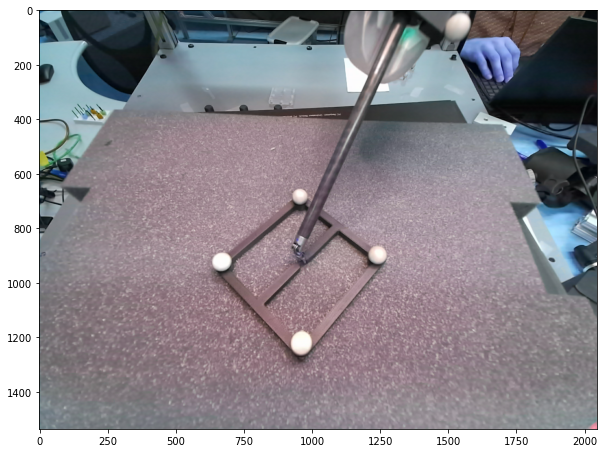

In [5]:
img_idx = 100
t = img_ts[img_idx]
robot_state_msg_idx = np.argmin(np.abs(t - robot_state_ts))
left_joint_angles = robot_state_list[robot_state_msg_idx]
left_joint_angles_orderred = np.array(left_joint_angles.position)[[2, 4, 3, 0, 6, 5, 7]]

#tf_msg_idx = np.argmin(np.abs(t - left_wrist_end_frame_ts))
#tf_msg = left_wrist_end_frame_list[tf_msg_idx]

cv_img = bridge.imgmsg_to_cv2(img_list[img_idx], desired_encoding="passthrough")
img = cv_img[:,:,:3].copy()

plt.figure(figsize=(10,10))

plt.imshow(img)

In [6]:
def segmentColorAndGetKeyPoints(img, hsv_min=(90, 40, 40), hsv_max=(120, 255, 255), draw_contours=False):
    hsv = cv2.cvtColor(img,  cv2.COLOR_RGB2HSV)
    mask  = cv2.inRange(hsv , hsv_min, hsv_max)
    mask  = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((5,5),np.uint8))

    cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cnts = imutils.grab_contours(cnts)

    centroids = []
    for c in cnts:
        # compute the center of the contour
        M = cv2.moments(c)
        if M["m00"] == 0:
            cX = M["m10"]
            cY = M["m01"]
        else:
            cX = M["m10"] / M["m00"]
            cY = M["m01"] / M["m00"]
        centroids.append(np.array([cX, cY]))

    if draw_contours:
        cv2.drawContours(img, cnts, -1, (255, 0, 0), thickness=3)
    
    return np.array(centroids), img

In [7]:
hsv_min=(120, 40, 40)
hsv_max=(150, 255, 255)
centroids, image = segmentColorAndGetKeyPoints(img.copy(), hsv_min, hsv_max, draw_contours=True)
centroids

array([[ 983.34482759,  922.22068966],
       [ 965.83722741,  926.66744548],
       [ 948.65232975,  896.89605735],
       [ 962.25      ,  895.42531447],
       [ 948.18864469,  841.48901099],
       [1080.91826309,  623.15453384],
       [1771.24782609,  546.6826087 ]])

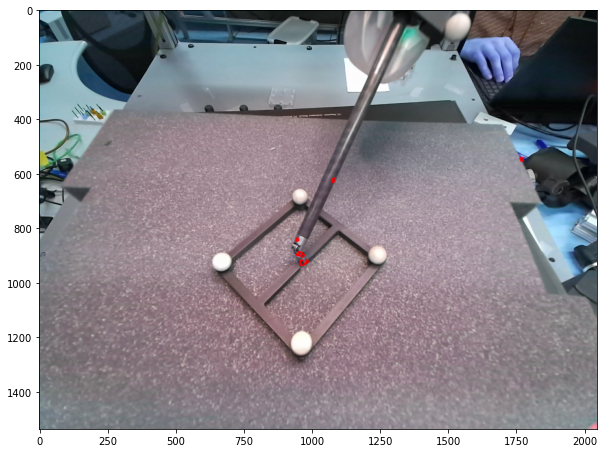

In [8]:
plt.figure(figsize=(10,10))

plt.imshow(image)

# test tool projection with initialization

In [9]:
taurus = Taurus_FK("point_feature_markers.json")

T_b_c = np.array([[-0.0086596 ,  0.86086372, -0.50876189, 0.667792],
                  [-0.9999511 , -0.00502532,  0.00851687, -0.027447],
                  [ 0.00477517,  0.50881076,  0.86086515, -0.0123208],
                  [ 0.0       , 0.0        , 0.0        , 1.0     ]])
T_c_b = np.linalg.inv(T_b_c)


In [10]:
rvec_init = cv2.Rodrigues(T_c_b[:3,:3])[0].squeeze()
tvec_init = T_c_b[:3,-1]

In [11]:
T_J5 = taurus.get_elbow_transfrom(left_joint_angles_orderred[0],\
                            left_joint_angles_orderred[1],\
                                left_joint_angles_orderred[2],\
                                    left_joint_angles_orderred[3])

T_J6 = taurus.get_end_frame_transform(left_joint_angles_orderred[0],\
                            left_joint_angles_orderred[1],\
                                left_joint_angles_orderred[2],\
                                    left_joint_angles_orderred[3],\
                                        left_joint_angles_orderred[4],\
                                            left_joint_angles_orderred[5],\
                                                left_joint_angles_orderred[6])
ori = T_J5 @ np.array([0,0,0,1])
x = T_J5 @ np.array([0.05,0,0,1])
y = T_J5 @ np.array([0,0.05,0,1])
z = T_J5 @ np.array([0,0,0.05,1])

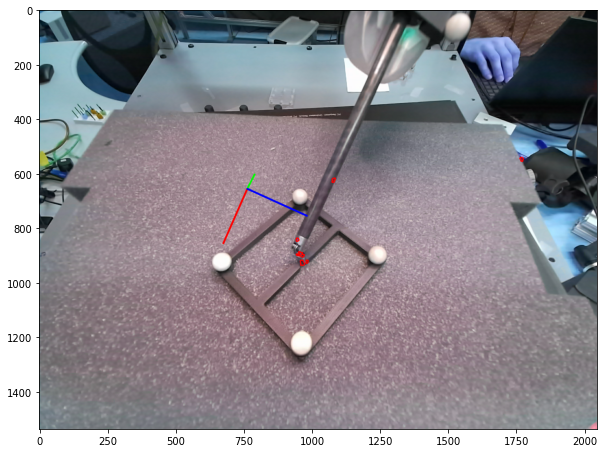

In [12]:
px,_ = cv2.projectPoints(x[:3], rvec_init, tvec_init, P, D)
py,_ = cv2.projectPoints(y[:3], rvec_init, tvec_init, P, D)
pz,_ = cv2.projectPoints(z[:3], rvec_init, tvec_init, P, D)
po,_ = cv2.projectPoints(ori[:3], rvec_init, tvec_init, P, D)

color = (255,0,0)
image = cv2.line(image, tuple(po.squeeze().astype(int)), tuple(px.squeeze().astype(int)), 
                                 (255,0,0), 5)
image = cv2.line(image, tuple(po.squeeze().astype(int)), tuple(py.squeeze().astype(int)), 
                                 (0,255,0), 5)
image = cv2.line(image, tuple(po.squeeze().astype(int)), tuple(pz.squeeze().astype(int)), 
                                 (0,0,255), 5)

plt.figure(figsize=(10,10))

plt.imshow(image)

roll_1:front
[[[773.63078046 633.90640307]]]
roll_1:back
[[[778.62413319 624.20769392]]]
roll_2:right
[[[783.18803166 664.40314011]]]
roll_2:left
[[[745.35611342 647.45002223]]]
pitch_2:front
[[[756.14193098 670.98380817]]]
pitch_2:back
[[[762.32239601 664.49973166]]]
pitch_1:right
[[[770.87335141 679.50153988]]]
pitch_1:left
[[[744.55347007 663.12710085]]]
pitch_3:front
[[[770.43957153 698.97749251]]]
pitch_3:back
[[[779.66948848 682.71857608]]]
yaw_1
[[[781.80235951 723.14952917]]]
yaw_2
[[[785.69977076 714.77053128]]]


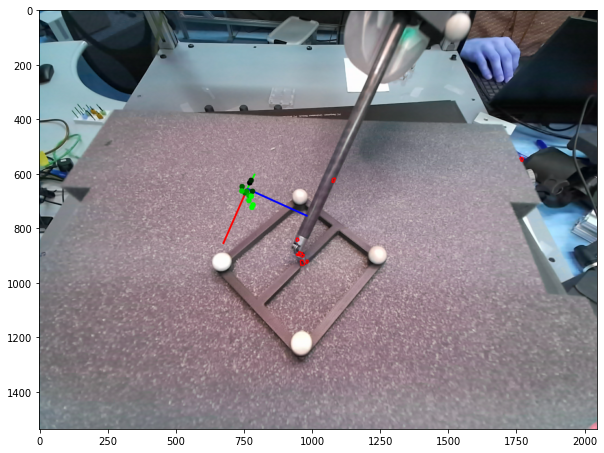

In [13]:
point_features = taurus.get_point_features(left_joint_angles_orderred)



c = 0
for key in list(point_features.keys())[:]:
    print(key)
    p = point_features[key]
    point,_ = cv2.projectPoints(p, rvec_init, tvec_init, P, D)
    print(point)
    image = cv2.circle(image,tuple(point.squeeze().astype(int)), 10, (0,c,0), -1)

    c+=30


plt.figure(figsize=(10,10))

plt.imshow(image)

# functions defined observation model for particle filter

In [18]:
#kwargs must have init_rvec, init_tvec, and joint_angles
def project_feature_points(x, **kwargs):
    

    theta = kwargs["joint_angles"]
    robot = kwargs["robot"]
    cam = kwargs["camera"]
    point_features = taurus.get_point_features(theta)

    f0 = point_features['roll_1:front']
    f1 = point_features['roll_1:back']
    f2 = point_features['roll_2:right']
    f3 = point_features['roll_2:left']
    f4 = point_features['pitch_1:right']
    f5 = point_features['pitch_1:left']
    f6 = point_features['pitch_2:front']
    f7 = point_features['pitch_2:back']
    ### markers on the wrist joint
    f8 = point_features['pitch_3:front']
    f9 = point_features['pitch_3:back']
    ### markers on gripper
    f10 = point_features['yaw_1']
    f11 = point_features['yaw_2']



    n_points = len(point_features.keys())
    y = np.zeros((x.shape[0], n_points, 2))



    for i, particle in enumerate(x):
        
        rvec, tvec = cv2.composeRT( kwargs["init_rvec"], kwargs["init_tvec"], particle[3:], particle[:3])[:2]
        
        p0,_ = cv2.projectPoints(f0, rvec, tvec, cam.P,cam.D)
        p0 = np.squeeze(p0) - cam.offset
        y[i, 0] = p0
        p1,_ = cv2.projectPoints(f1, rvec, tvec, cam.P,cam.D)
        p1 = np.squeeze(p1) - cam.offset
        y[i, 1] = p1
        p2,_ = cv2.projectPoints(f2, rvec, tvec, cam.P,cam.D)
        p2 = np.squeeze(p2) - cam.offset
        y[i, 2] = p2
        p3,_ = cv2.projectPoints(f3, rvec, tvec, cam.P,cam.D)
        p3 = np.squeeze(p3) - cam.offset
        y[i, 3] = p3
        p4,_ = cv2.projectPoints(f4, rvec, tvec, cam.P,cam.D)
        p4 = np.squeeze(p4) - cam.offset
        y[i, 4] = p4
        p5,_ = cv2.projectPoints(f5, rvec, tvec, cam.P,cam.D)
        p5 = np.squeeze(p5) - cam.offset
        y[i, 5] = p5
        p6,_ = cv2.projectPoints(f6, rvec, tvec, cam.P,cam.D)
        p6 = np.squeeze(p6) - cam.offset
        y[i, 6] = p6
        p7,_ = cv2.projectPoints(f7, rvec, tvec, cam.P,cam.D)
        p7 = np.squeeze(p7) - cam.offset
        y[i, 7] = p7
        ### markers on the wrist joint
        p8,_ = cv2.projectPoints(f8, rvec, tvec, cam.P,cam.D)
        p8 = np.squeeze(p8) - cam.offset
        y[i, 8] = p8
        p9,_ = cv2.projectPoints(f9, rvec, tvec, cam.P,cam.D)
        p9 = np.squeeze(p9) - cam.offset
        y[i, 9] = p9
        ### markers on the gripper
        p10,_ = cv2.projectPoints(f10, rvec, tvec, cam.P,cam.D)
        p10 = np.squeeze(p10) - cam.offset
        y[i, 10] = p10
        p11,_ = cv2.projectPoints(f11, rvec, tvec, cam.P,cam.D)
        p11 = np.squeeze(p11) - cam.offset
        y[i, 11] = p11
        
    return y

In [23]:
# Note that hypotheses is of dimensions N (number of particles) by P (number of features) by 2 
# and observed is of dimensions P by 2

def weight_function(hypotheses, observed, **kwargs):
    n_particles = hypotheses.shape[0]
    weights = np.zeros(n_particles)

    for i in range(n_particles):
        projected_points = hypotheses[i]
        # Use hungarian algorithm to match projected and detected points
        C = np.linalg.norm(projected_points[:, None, :] - observed[None, :,  :], axis=2)
        #print(C)
        row_idx, col_idx = optimize.linear_sum_assignment(C)

        # Use threshold to remove outliers
        idx_to_keep = C[row_idx, col_idx] < kwargs["association_threshold"]
        row_idx = row_idx[idx_to_keep]
        col_idx = col_idx[idx_to_keep]

        # Compute observation probability
        prob = np.mean(np.exp(-kwargs["gamma"]*C[row_idx, col_idx])) 
        #print(prob)
        weights[i] = prob

    weights[np.isnan(weights)] = 0        

    return weights


# tracking with particle filter 

In [38]:
# particle filter parameters
sigma_t = 0.001 #0.005 #inch
sigma_r = 0.001   #0.035 #2 degrees
#sigma_j = 0.001
#u_j     = 0.002
scale_init_sigma = 10
gamma = 0.5 # 1
association_threshold=500
n_particles = 500
n_eff = 0.5
resample_proportion = 0

# initialize particle filter
pf = ParticleFilter(prior_fn=lambda n : prior_fn(n, scale_init_sigma, sigma_t, sigma_r), 
                    observe_fn=project_feature_points,
                    n_particles=n_particles,
                    dynamics_fn=identity,
                    noise_fn=lambda x, **kwargs: 
                                gaussian_noise(x, sigmas=[sigma_t, sigma_t, sigma_t, 
                                                          sigma_r, sigma_r, sigma_r]),
                    weight_fn=weight_function,
                    resample_proportion=resample_proportion,
                    resample_fn = stratified_resample,
                    n_eff_threshold = n_eff)
pf.init_filter() 


3.137107997909712e-54
[[[594.72960575 -31.33233172]]]
[[[614.69285108   5.05208907]]]
[[[613.92149778  66.29432174]]]
[[[545.43325578  16.34895964]]]
[[[559.14631163  52.57798039]]]
[[[578.69300197  76.80385679]]]
[[[587.66291457  85.38592287]]]
[[[544.1497362   59.09068576]]]
[[[576.02999252 135.49853741]]]
[[[595.46431864 139.45175976]]]
[[[585.0804093  224.52358273]]]
[[[596.24162055 203.24810994]]]


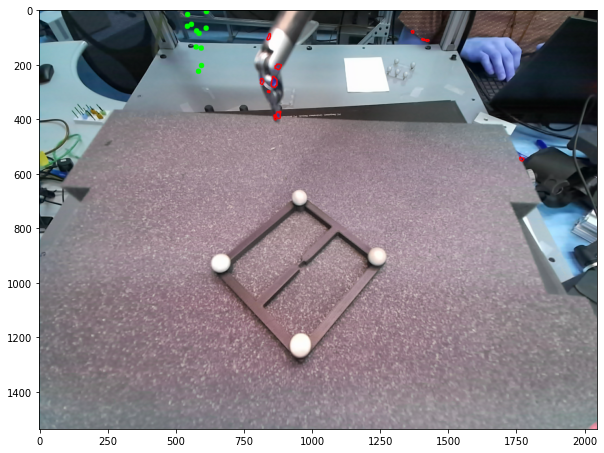

In [39]:
idx = 0
# receive images
cv_img = bridge.imgmsg_to_cv2(img_list[idx], desired_encoding="passthrough")
img = cv_img[:,:,:3].copy()

# receive joint angles
t = img_ts[idx]
robot_state_msg_idx = np.argmin(np.abs(t - robot_state_ts))
left_joint_angles = robot_state_list[robot_state_msg_idx]
left_joint_angles_orderred = np.array(left_joint_angles.position)[[2, 4, 3, 0, 6, 5, 7]]

# detect point features
centroids, img = segmentColorAndGetKeyPoints(img, hsv_min, hsv_max, draw_contours=True)

# estimate with particle filter
pf.update(centroids, init_rvec=rvec_init, init_tvec=tvec_init,\
            joint_angles=left_joint_angles_orderred, association_threshold=association_threshold,\
            gamma=gamma, robot=taurus, camera=camera)

# most recent prediction of the robot pose
rvec_new, tvec_new = cv2.composeRT(rvec_init, tvec_init, pf.mean_state[3:], pf.mean_state[:3], 
                        camera.P, camera.D)[:2]

image = img.copy()

point_features = taurus.get_point_features(left_joint_angles_orderred)

for key in point_features.keys():
    p = point_features[key]
    point,_ = cv2.projectPoints(p, rvec_new, tvec_new, P, D)
    print(point)
    image = cv2.circle(image,tuple(point.squeeze().astype(int)), 10, (0,255,0), -1)


plt.figure(figsize=(10,10))

plt.imshow(image)



In [40]:

video = cv2.VideoWriter("video_with_markers.mp4",  cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), 20, (img.shape[1],img.shape[0]))

for idx in range(0, 400):
    
    # receive images
    cv_img = bridge.imgmsg_to_cv2(img_list[idx], desired_encoding="passthrough")
    img = cv_img[:,:,:3].copy()
    
    # receive joint angles
    t = img_ts[idx]
    robot_state_msg_idx = np.argmin(np.abs(t - robot_state_ts))
    left_joint_angles = robot_state_list[robot_state_msg_idx]
    left_joint_angles_orderred = np.array(left_joint_angles.position)[[2, 4, 3, 0, 6, 5, 7]]
    
    # detect point features
    centroids, img = segmentColorAndGetKeyPoints(img, hsv_min, hsv_max, draw_contours=True)

    
    # estimate with particle filter
    # estimate with particle filter
    pf.update(centroids, init_rvec=rvec_init, init_tvec=tvec_init,\
                joint_angles=left_joint_angles_orderred, association_threshold=association_threshold,\
                gamma=gamma, robot=taurus, camera=camera)
    
    # most recent prediction of the robot pose
    rvec_new, tvec_new = cv2.composeRT(rvec_init, tvec_init, pf.mean_state[3:], pf.mean_state[:3], 
                           camera.P, camera.D)[:2]
    
    ####################################
    # draw estimation
    point_features = taurus.get_point_features(left_joint_angles_orderred)

    image = img.copy()

    T_J5 = taurus.get_elbow_transfrom(left_joint_angles_orderred[0],\
                                        left_joint_angles_orderred[1],\
                                            left_joint_angles_orderred[2],\
                                                left_joint_angles_orderred[3])

    T_J6 = taurus.get_end_frame_transform(left_joint_angles_orderred[0],\
                                            left_joint_angles_orderred[1],\
                                                left_joint_angles_orderred[2],\
                                                    left_joint_angles_orderred[3],\
                                                        left_joint_angles_orderred[4],\
                                                            left_joint_angles_orderred[5],\
                                                                left_joint_angles_orderred[6])
    ori = T_J5 @ np.array([0,0,0,1])
    x = T_J5 @ np.array([0.02,0,0,1])
    y = T_J5 @ np.array([0,0.02,0,1])
    z = T_J5 @ np.array([0,0,0.02,1])

    px,_ = cv2.projectPoints(x[:3], rvec_new, tvec_new, P, D)
    py,_ = cv2.projectPoints(y[:3], rvec_new, tvec_new, P, D)
    pz,_ = cv2.projectPoints(z[:3], rvec_new, tvec_new, P, D)
    po,_ = cv2.projectPoints(ori[:3], rvec_new, tvec_new, P, D)

    image = cv2.line(image, tuple(po.squeeze().astype(int)), tuple(px.squeeze().astype(int)), 
                                    (255,0,0), 5)
    image = cv2.line(image, tuple(po.squeeze().astype(int)), tuple(py.squeeze().astype(int)), 
                                    (0,255,0), 5)
    image = cv2.line(image, tuple(po.squeeze().astype(int)), tuple(pz.squeeze().astype(int)), 
                                    (0,0,255), 5)
    '''
    ori = T_J6 @ np.array([0,0,0,1])
    x = T_J6 @ np.array([0.02,0,0,1])
    y = T_J6 @ np.array([0,0.02,0,1])
    z = T_J6 @ np.array([0,0,0.02,1])

    px,_ = cv2.projectPoints(x[:3], rvec_new, tvec_new, P, D)
    py,_ = cv2.projectPoints(y[:3], rvec_new, tvec_new, P, D)
    pz,_ = cv2.projectPoints(z[:3], rvec_new, tvec_new, P, D)
    po,_ = cv2.projectPoints(ori[:3], rvec_new, tvec_new, P, D)

    image = cv2.line(image, tuple(po.squeeze().astype(int)), tuple(px.squeeze().astype(int)), 
                                    (255,0,0), 5)
    image = cv2.line(image, tuple(po.squeeze().astype(int)), tuple(py.squeeze().astype(int)), 
                                    (0,255,0), 5)
    image = cv2.line(image, tuple(po.squeeze().astype(int)), tuple(pz.squeeze().astype(int)), 
                                    (0,0,255), 5)

    for key in point_features.keys():
        p = point_features[key]
        point,_ = cv2.projectPoints(p, rvec_new, tvec_new, P, D)
        image = cv2.circle(image,tuple(point.squeeze().astype(int)), 10, (0,255,0), -1)
    '''

    video.write(image)
    
video.release()

1.4679177941697022e-48
4.272669255674958e-41
1.6355805065565312e-33
4.777998970593734e-29
1.736748283353442e-24
1.829727566485206e-18
1.3957140736654876e-13
3.3190091428572454e-08
9.852271096469753e-05
0.00668154582572371
0.004115782862978789
0.0025833604848819226
0.002671412875898245
0.0006597668432110467
0.0029223251383439608
0.001879400395454133
0.0042372094717239486
0.003251259698934955
0.0058207205358345795
0.00451472201552868
0.0069741358085758974
0.004458796791341894
0.006528290481903261
0.012951014578629738
0.011646576007031494
0.008510651914058032
0.005700420006221804
0.009576099272555365
0.006023966159697676
0.004537150568489529
0.015871272620939344
0.003623941906097675
0.014663424550296702
0.0056456582073412705
0.011969665023425488
0.015978355902571177
0.009845360968561988
0.007921406732033455
0.005495055885150245
0.010414053339864332
0.005460780679599699
0.020607356578234946
0.014412014683666225
0.005104342568820371
0.013268707590738175
0.005876807163885839
0.00480154265115